In [9]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conn = sqlite3.connect("TPC-H-DB.db")

# Show all tables in the database
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

conn.close()


       name
0    NATION
1    REGION
2      PART
3  SUPPLIER
4  PARTSUPP
5  CUSTOMER
6    ORDERS
7  LINEITEM


In [10]:
def test(db_path, sql_query):
    """
    Connects to SQLite database, runs a SQL query, and returns the results as a DataFrame.
    
    Args:
        db_path (str): Path to the SQLite .db file.
        sql_query (str): SQL query string to execute.
        
    Returns:
        pd.DataFrame: Query results.
    """
    try:
        conn = sqlite3.connect(db_path)
        df = pd.read_sql(sql_query, conn)
        conn.close()
        return df
    except Exception as e:
        print(f"Error running query: {e}")
        return None

# Example usage:
if __name__ == "__main__":
    db_file = "TPC-H-DB.db"
    query = "SELECT COUNT(*) AS order_count FROM orders;"
    result_df = test(db_file, query)
    print(result_df)


   order_count
0        15000


In [ ]:
def run_sql_query(db_path, sql_query):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql(sql_query, conn)
    conn.close()
    return df

db_file = "TPC-H-DB.db"


/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_11339/1532312080.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="year", y="total_revenue", data=revenue_df, palette="Blues_d")


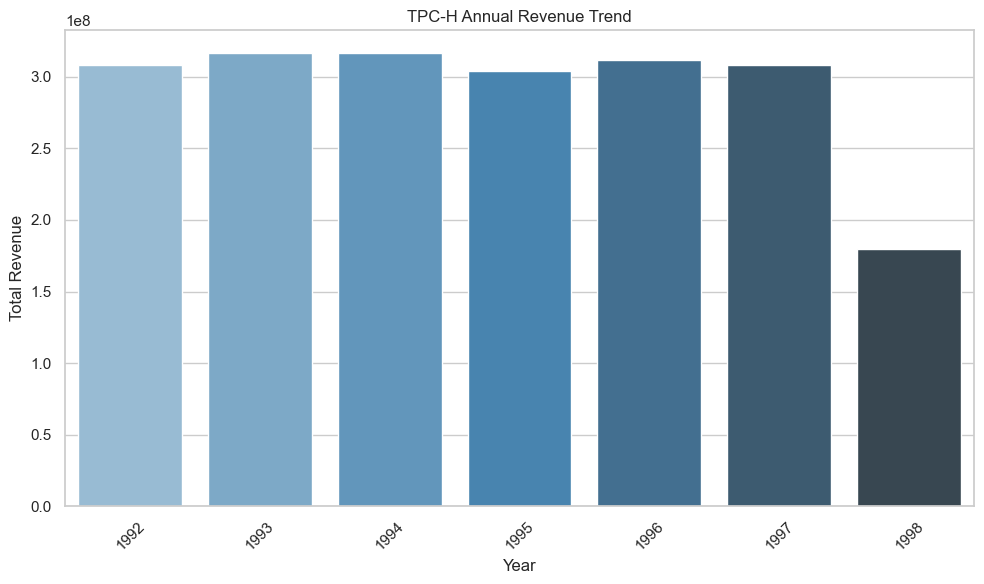

In [ ]:
# Total revenue for each year

# SQL query for annual revenue
query = """
SELECT
    substr(o_orderdate, 1, 4) AS year,
    ROUND(SUM(l_extendedprice * (1 - l_discount)), 2) AS total_revenue
FROM
    orders
JOIN
    lineitem ON orders.o_orderkey = lineitem.l_orderkey
GROUP BY
    year
ORDER BY
    year;
"""


revenue_df = run_sql_query(db_file, query)

# Visualize
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="total_revenue", data=revenue_df, palette="Blues_d")
plt.title("TPC-H Annual Revenue Trend")
plt.xlabel("Year")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Index(['C_CUSTKEY', 'C_NAME', 'total_spent'], dtype='object')
   C_CUSTKEY              C_NAME  total_spent
0       1489  Customer#000001489   5203674.05
1        214  Customer#000000214   4503703.90
2         73  Customer#000000073   4466381.05
3       1246  Customer#000001246   4465335.62
4       1396  Customer#000001396   4455381.82


/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_11339/3760346071.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


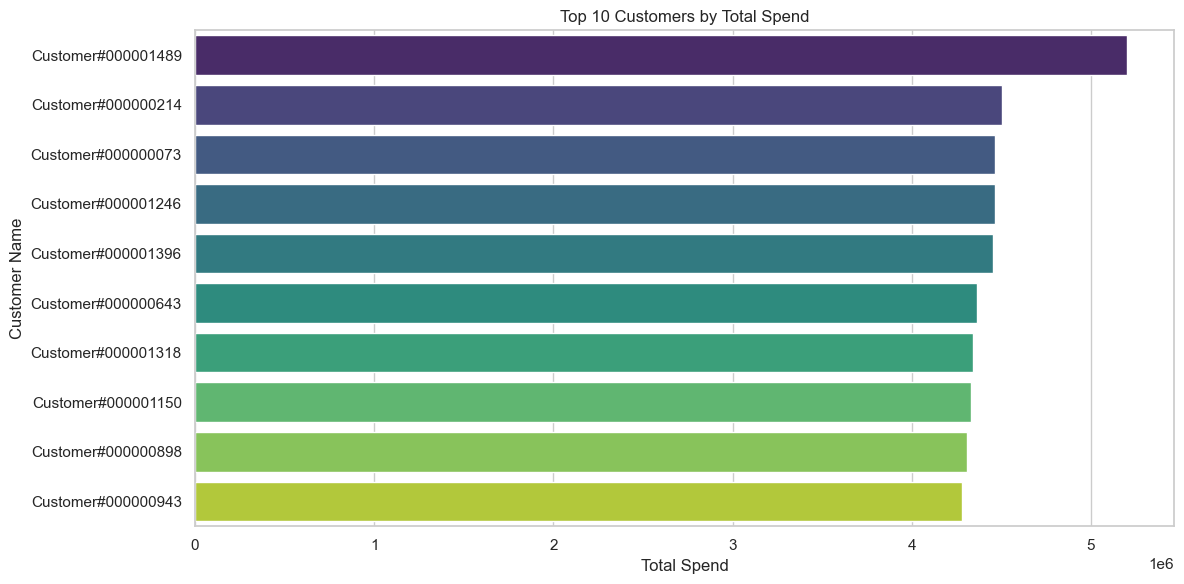

In [15]:
# Identify the top 10 customers who have spent the most, based on order line items, and visualize their spending.

query = """
SELECT
    c_custkey,
    c_name,
    ROUND(SUM(l_extendedprice * (1 - l_discount)), 2) AS total_spent
FROM
    customer c
JOIN
    orders o ON c.c_custkey = o.o_custkey
JOIN
    lineitem l ON o.o_orderkey = l.l_orderkey
GROUP BY
    c_custkey, c_name
ORDER BY
    total_spent DESC
LIMIT 10;
"""


top_customers_df = run_sql_query(db_file, query)
print(top_customers_df.columns)
print(top_customers_df.head())
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    x="total_spent",
    y="C_NAME",
    data=top_customers_df,
    palette="viridis"
)
plt.title("Top 10 Customers by Total Spend")
plt.xlabel("Total Spend")
plt.ylabel("Customer Name")
plt.tight_layout()
plt.show()


  ship_mode  shipment_count  total_revenue
0     TRUCK            8710   2.975970e+08
1      MAIL            8669   2.950573e+08
2       FOB            8641   2.922316e+08
3   REG AIR            8616   2.915085e+08
4      RAIL            8566   2.899358e+08
5       AIR            8491   2.881191e+08
6      SHIP            8482   2.906856e+08


/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_11339/2480327719.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ship_mode", y="shipment_count", data=shipmode_df, palette="Set2")


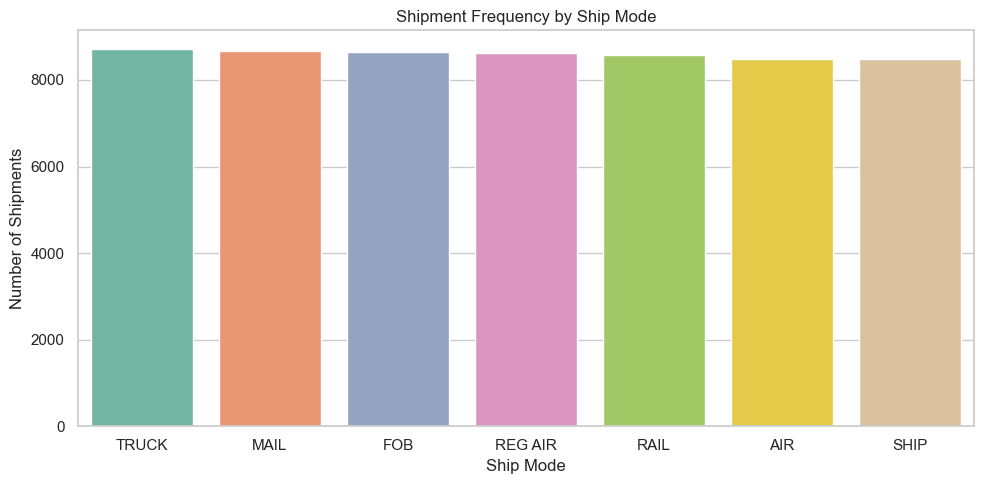

/var/folders/1m/lj3knm290l95p0fsr7jzt02c0000gn/T/ipykernel_11339/2480327719.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ship_mode", y="total_revenue", data=shipmode_df, palette="Set1")


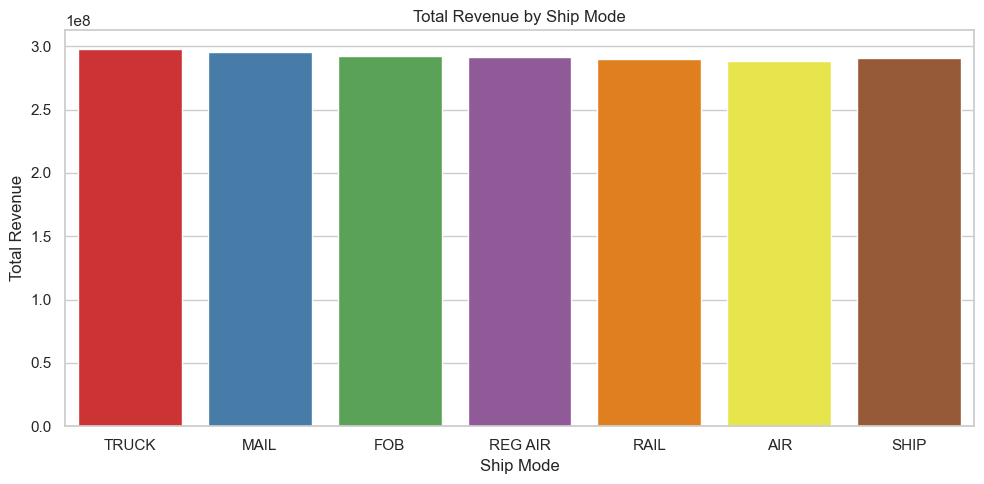

In [16]:
# Find the most frequently used shipping methods and how much revenue is associated with each.

query = """
SELECT
    l_shipmode AS ship_mode,
    COUNT(*) AS shipment_count,
    ROUND(SUM(l_extendedprice * (1 - l_discount)), 2) AS total_revenue
FROM
    lineitem
GROUP BY
    l_shipmode
ORDER BY
    shipment_count DESC;
"""

shipmode_df = run_sql_query(db_file, query)
print(shipmode_df)

# Plot shipment count
plt.figure(figsize=(10, 5))
sns.barplot(x="ship_mode", y="shipment_count", data=shipmode_df, palette="Set2")
plt.title("Shipment Frequency by Ship Mode")
plt.xlabel("Ship Mode")
plt.ylabel("Number of Shipments")
plt.tight_layout()
plt.show()

# Plot total revenue by ship mode
plt.figure(figsize=(10, 5))
sns.barplot(x="ship_mode", y="total_revenue", data=shipmode_df, palette="Set1")
plt.title("Total Revenue by Ship Mode")
plt.xlabel("Ship Mode")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()
